# PRICE PREDICTION WITH XGBOOST VS CATBOOST REGRESSORS

## Import Dependencies

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import  LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics

### Load and Clean the Data

In [43]:
df = pd.read_csv(r'C:\Users\yusuf\Desktop\Workspace url/Trendyol_detailed2.csv')       ## Load the data
df.head(3)

,Unnamed: 0,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Battery Power,Color,Link
0,939,Y21 4gb/64gb,İNOVELSTORE,3399,NaN,4.0,64.0,Android,NaN,NaN,NaN,Mavi,https://www.trendyol.com/vivo/y21-4gb-64gb-p-2...
1,516,Y21 V2111,Çimenli İletişim,3327,NaN,4.0,64.0,Android,NaN,NaN,NaN,Beyaz,https://www.trendyol.com/vivo/y21-v2111-4gb-64...
2,723,1S 2020,Alcatel,2069,1.5-2.0,3.0,32.0,Android,12.5,6.0,3000 - 4000,Gri,https://www.trendyol.com/alcatel/1s-2020-32gb-...


In [44]:
df.drop(columns=['Unnamed: 0','Link','Battery Power'], axis= 1, inplace=True)            ## Drop unused columns
df.head(3)

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
0,Y21 4gb/64gb,İNOVELSTORE,3399,NaN,4.0,64.0,Android,NaN,NaN,Mavi
1,Y21 V2111,Çimenli İletişim,3327,NaN,4.0,64.0,Android,NaN,NaN,Beyaz
2,1S 2020,Alcatel,2069,1.5-2.0,3.0,32.0,Android,12.5,6.0,Gri


In [45]:
df.info()             ## see the null values and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              1176 non-null   object 
 1   Brand              1176 non-null   object 
 2   Price              1176 non-null   int64  
 3   CPU                482 non-null    object 
 4   RAM                1156 non-null   float64
 5   Storage            1147 non-null   float64
 6   Operating System   1166 non-null   object 
 7   Camera Resolution  872 non-null    float64
 8   Screen Size        807 non-null    float64
 9   Color              1118 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 92.0+ KB


### Fill missing values

There are a lot of missing values but it is easy to fill the missing values by googling the hardware specifications of smartphone models. Same models generally have the same hardware. If possible, this should be considered as a way to impute missing values rather than blindly dropping, or filling the nulls with mean,mode values. It is a version of filling the nulls with mode of the dataset.

In [46]:
## Get indices for the rows of apple iphone 13 models with null cpu column

pp = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('13')==True),'Model'].index

In [47]:
## insert a specific value for the indices defined in the cell above.
df.loc[pp,'CPU'] = 3.2      

In [48]:
## Get indices for the rows of apple iphone S models with null cpu column
rr = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('S')),'Model'].index
## insert a specific value for the indices defined above.
df.loc[rr,'CPU'] = 2.6

In [49]:
## Get indices for the rows of apple iphone 12 models with null cpu column
tt = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('12')),'Model'].index
## insert a specific value for the indices defined above.
df.loc[tt,'CPU'] = 3.2
df.loc[tt]

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
92,Iphone 12,Apple,27999,3.2,6.0,128.0,Android,NaN,6.25,Sar
144,Iphone 12,Apple,32599,3.2,3.0,256.0,iOS,50.0,NaN,G
146,İphone 12,Apple,30000,3.2,6.0,128.0,iOS,12.5,6.25,G
179,Iphone 12,Apple,18972,3.2,4.0,64.0,iOS,12.5,6.25,Mor
192,Iphone se 128gb,Apple,11949,3.2,3.0,128.0,iOS,12.5,NaN,K
195,Iphone 12,Apple,22249,3.2,4.0,256.0,iOS,12.5,6.25,Ye


In [50]:
df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True),'CPU'] = 2.8

In [51]:
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)].groupby('Model').count().sort_values('Brand',ascending=False).head()

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Galaxy S22,20,20,0,20,20,20,16,0,20
Galaxy S21,11,11,0,11,11,11,8,1,7
Galaxy Z,11,11,0,11,11,11,2,0,11
Galaxy A13,9,9,0,9,9,9,8,2,9
Galaxy A22,9,9,0,9,9,9,8,0,8


In [52]:
## impute values for specific phone models. the inputs are checked online

df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S22'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S21'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy Z'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A73'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A13'),'CPU'] = 2.2 
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A22'),'CPU'] = 2.2
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S22+'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A12'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A52s'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy Note20'),'CPU'] = 2.6
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A03s'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy J1'),'CPU'] = 1.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A33'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S20'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A23'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A51'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A53'),'CPU'] = 2.4

In [53]:
df.CPU.replace(['0.5-1.0','1.5-2.0','1.0-1.5','2.5-3.2', '2.0-2.5'],[0.8,1.8,1.3,2.8,2.3],inplace=True)

In [54]:
df.loc[df['Camera Resolution'].isna()==True].groupby('Model').count().sort_values('Brand',ascending=False)

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Redmi Note,40,40,6,39,39,40,0,19,37
P13 Blue,13,13,0,12,13,13,0,6,13
Iphone 13,13,13,13,13,13,13,0,10,8
Galaxy Z,9,9,9,9,9,9,0,0,9
Gm 22,8,8,0,8,8,8,0,0,8
...,...,...,...,...,...,...,...,...,...
Hiking A27,1,1,0,1,1,1,0,0,1
Gt Master,1,1,0,1,1,1,0,1,1
Galaxy S22+,1,1,1,1,1,1,0,1,1


In [55]:
tt=df[df.Model=='Redmi Note'].index                ## get the index numbers of the this model

In [56]:
df.loc[tt,'CPU'] = 2.3                              ## change the CPU values of this model. 

In [57]:
df.loc[(df.Model=='P13 Blue')&(df.CPU.isna()==True),'CPU']=2.4                

In [58]:
df.loc[(df.Model=='Redmi Note')&(df['Camera Resolution'].isna()==True),'Camera Resolution'] = 48

In [59]:
df.loc[(df.Model=='Iphone 13')&(df['Camera Resolution'].isna()==True),'Camera Resolution'] = 12

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              1176 non-null   object 
 1   Brand              1176 non-null   object 
 2   Price              1176 non-null   int64  
 3   CPU                812 non-null    float64
 4   RAM                1156 non-null   float64
 5   Storage            1147 non-null   float64
 6   Operating System   1166 non-null   object 
 7   Camera Resolution  925 non-null    float64
 8   Screen Size        807 non-null    float64
 9   Color              1118 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 92.0+ KB


In [61]:
df[df['Screen Size'].isna()==True].groupby('Model').count().sort_values('CPU',ascending=False).head()

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Redmi Note,30,30,30,30,30,30,30,0,28
Galaxy S22,20,20,20,20,20,20,16,0,20
Galaxy Z,11,11,11,11,11,11,2,0,11
P13 Blue,11,11,11,11,11,11,4,0,11
Galaxy S21,10,10,10,10,10,10,8,0,6


In [62]:
## impute values for specific phone models. the inputs are checked online

df.loc[(df.Model=='Redmi Note')&(df['Screen Size'].isna()==True),'Screen Size'] = 6
df.loc[(df.Model=='Galaxy S22')&(df['Screen Size'].isna()==True),'Screen Size'] = 6
df.loc[(df.Model=='Galaxy S21')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.2
df.loc[(df.Model=='Galaxy Z')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.7
df.loc[(df.Model=='P13 Blue')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.2
df.loc[(df.Model=='iPhone SE')&(df['Screen Size'].isna()==True),'Screen Size'] = 4.7
df.loc[(df.Model=='Galaxy A73')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.7
df.loc[(df.Model=='Galaxy A22')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.4
df.loc[(df.Model=='Galaxy S22+')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.6

In [63]:
brands=df.groupby('Brand').count().sort_values('Model',ascending=False).index[:10]    ## get the names of the top 10 brands

In [64]:
df1 =df.loc[df.Brand.isin(brands)==True]                          ## Create a data frame with only the top 10 brands
df1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 12 to 1160
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              936 non-null    object 
 1   Brand              936 non-null    object 
 2   Price              936 non-null    int64  
 3   CPU                727 non-null    float64
 4   RAM                934 non-null    float64
 5   Storage            928 non-null    float64
 6   Operating System   934 non-null    object 
 7   Camera Resolution  744 non-null    float64
 8   Screen Size        772 non-null    float64
 9   Color              883 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 80.4+ KB


In [65]:
## convert Turkish words into English 
ders = {'Siyah':'Black','Mavi':'Blue','Beyaz':'White','Ye':'Green','Gri':'Gray','Mor':'Purple','K':'Red',
                  'Alt':'Golden','Pembe':'Pink','Sar':'Yellow','Turuncu':'Orange','Metalik':'Metallic','Lacivert':'Blue',
                  'Turkuaz':'Turquoise','Bej':'Cream','Bordo':'Red','Kahverengi':'Brown'}


In [66]:
a= pd.json_normalize(ders).columns
b = pd.json_normalize(ders).T.iloc[:,0].values
b

array(['Black', 'Blue', 'White', 'Green', 'Gray', 'Purple', 'Red',
       'Golden', 'Pink', 'Yellow', 'Orange', 'Metallic', 'Blue',
       'Turquoise', 'Cream', 'Red', 'Brown'], dtype=object)

In [67]:
df.replace(a,b,inplace=True)              ## replace the Turkish values with the English ones.

In [68]:
df.groupby('Color').count().sort_values('Model',ascending=False).head(5)    ## get the color numbers and sort descending

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
Color,,,,,,,,,
Black,270,270,270,172,261,260,268,203,201
Blue,266,266,266,172,265,265,266,217,204
White,157,157,157,119,154,148,153,130,126
Green,119,119,119,93,118,118,119,92,102
Gray,114,114,114,85,113,111,112,95,97


In [81]:
df1.drop(columns='Price').head(100)

,Model,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
12,iPhone 13,Apple,3.2,6.0,128.0,iOS,7.5,6.25,Red
13,iPhone SE,Apple,1.8,2.0,64.0,iOS,12.5,4.00,Black
14,iPhone 11,Apple,2.8,4.0,128.0,iOS,12.5,6.00,Black
15,iPhone 11,Apple,2.8,4.0,64.0,iOS,12.5,6.00,Purple
16,iPhone 11,Apple,2.8,4.0,128.0,iOS,12.5,6.00,White
...,...,...,...,...,...,...,...,...,...
107,iPhone 13,Apple,3.2,6.0,512.0,iOS,7.5,6.25,Black
108,iPhone 13,Apple,3.2,6.0,512.0,iOS,7.5,6.25,Pink
109,iPhone 13,Apple,3.2,4.0,512.0,iOS,12.5,6.25,Green
110,iPhone 12,Apple,2.8,6.0,512.0,iOS,12.5,6.00,Golden


In [82]:
## Standardize the model names, different capitalization and misspelings make the data look bad.
df.loc[(df.Model.str.contains('13')==True)&(df.Brand=='Apple'),'Model']='iPhone 13'  

In [83]:
df1 =df.loc[df.Brand.isin(brands)==True]     

In [84]:
# df1.to_csv('smartphone_colors.csv')      ## save the dataframe before dropping the color column
df1 = df1.drop(columns='Color')                   ##  Drop the color column
   

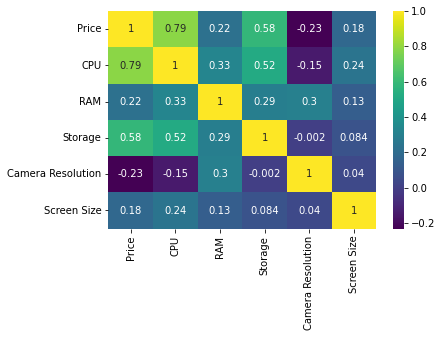

In [85]:
cor = df1.corr()                                  ## correlation martix
sns.heatmap(cor,annot= True , cmap = 'viridis' ) 
plt.show()

In [86]:
df1.dropna(inplace=True)             ## drop the null values that are not filled by now.

### Select Features and Split the Data

I drop 'Model' and 'Color' column because I do not think these are not as effective as other features on price

In [87]:
x= df1.drop(columns = ['Price','Model'])             ## split the features and the label 
x

,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
12,Apple,3.2,6.0,128.0,iOS,7.5,6.25
13,Apple,1.8,2.0,64.0,iOS,12.5,4.00
14,Apple,2.8,4.0,128.0,iOS,12.5,6.00
15,Apple,2.8,4.0,64.0,iOS,12.5,6.00
16,Apple,2.8,4.0,128.0,iOS,12.5,6.00
...,...,...,...,...,...,...,...
1154,Xiaomi,2.3,2.0,32.0,Android,12.5,6.00
1155,Xiaomi,2.3,3.0,64.0,Android,12.5,6.00
1156,Xiaomi,2.3,4.0,128.0,Android,50.0,6.25
1159,Xiaomi,2.3,4.0,128.0,Android,20.0,6.00


In [88]:
le = LabelEncoder()                               ## call label encoder to convert the categorical data into numerical data
x1 = le.fit_transform(x.Brand.values)              ## convert the brand column
x2 = le.fit_transform(x['Operating System'].values)     ## conver the OS column

In [90]:
x.Brand = x1                              ## replace the columns with new format
x['Operating System']  = x2    
x.head(3)

,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
12,0,3.2,6.0,128.0,1,7.5,6.25
13,0,1.8,2.0,64.0,1,12.5,4.00
14,0,2.8,4.0,128.0,1,12.5,6.00


In [91]:
y = df1.Price   ## define target column

In [92]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)  ## split the data into test and train

### XGBoost Regressor

In [93]:
model = xgb.XGBRegressor()       ##call the model

In [94]:
params = {'max_depth' : [15,20,25],              ## define parameter values for tuning.
         'learning_rate':[0.3,0.5,0.7],
         'n_estimators':[300,400,500],
          'min_child_weight':[6,8,10]
         }

In [95]:
grid = GridSearchCV(model,param_grid=params,verbose=2,cv=3)    ## input the components and create a gridsearchcv module.

In [ ]:
grid.fit(x_train,y_train);       ## fit the data

In [97]:
grid.best_estimator_                   ## the gridsearchcv returns the best parameters values.

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [98]:
## pass in the best parameter values.
model_xgb=xgb.XGBRegressor(max_depth=15,min_child_weight=8,n_estimators=500,learning_rate=0.5)    

In [99]:
##  train the data with the tuned parameters.
model_1=model_xgb.fit(x_train,y_train)  

In [100]:
## make predictions

y_pred1=model_1.predict(x_test)

In [101]:
## measure the performance for different metrics.

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))
print('R2 score:', metrics.r2_score(y_pred1,y_test))

Mean Absolute Error: 1163.7010962115833
Mean Squared Error: 4535339.210361445
Root Mean Squared Error: 2129.6335859394794
R2 score: 0.953404811728709


### CatBoost Regressor

In [102]:
## call another model

model1=cb.CatBoostRegressor()

In [103]:
## define parameter values and apply them in a grid module

params1 = {'max_depth':[6,10,15],
          'iterations':[120,150,200],
          'learning_rate':[0.1,0.2,0.3]}

grid1=GridSearchCV(model1,param_grid=params1,verbose=2,cv=3)

In [ ]:
grid1.fit(x_train,y_train)

In [105]:
## get the best parameter values

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid1.best_estimator_)
print("\n The best score across ALL searched params:\n", grid1.best_score_)
print("\n The best parameters across ALL searched params:\n", grid1.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.963281414215737

 The best parameters across ALL searched params:
 {'iterations': 200, 'learning_rate': 0.2, 'max_depth': 10}


In [106]:
## use the best parameter values given by the gridsearchcv module
model_cb=cb.CatBoostRegressor(iterations=200,learning_rate=0.2,max_depth=10)

In [107]:
## fit the model 
model2=model_cb.fit(x_train,y_train)

0:	learn: 8469.9521889	total: 7.28ms	remaining: 1.45s
1:	learn: 7338.2462038	total: 11ms	remaining: 1.09s
2:	learn: 6378.3748265	total: 15.2ms	remaining: 999ms
3:	learn: 5557.3861541	total: 17.2ms	remaining: 845ms
4:	learn: 4866.6061368	total: 18.8ms	remaining: 732ms
5:	learn: 4331.0360167	total: 24.8ms	remaining: 802ms
6:	learn: 3846.1687805	total: 27ms	remaining: 745ms
7:	learn: 3493.2690512	total: 32.4ms	remaining: 778ms
8:	learn: 3145.0747791	total: 34.4ms	remaining: 730ms
9:	learn: 2942.5832673	total: 36.3ms	remaining: 689ms
10:	learn: 2760.8439737	total: 37.7ms	remaining: 648ms
11:	learn: 2630.5662899	total: 38.7ms	remaining: 606ms
12:	learn: 2506.3764908	total: 41.3ms	remaining: 595ms
13:	learn: 2389.8686118	total: 43.8ms	remaining: 581ms
14:	learn: 2319.9559994	total: 44.8ms	remaining: 552ms
15:	learn: 2237.5748443	total: 46.2ms	remaining: 531ms
16:	learn: 2136.9231211	total: 48.4ms	remaining: 521ms
17:	learn: 2064.6212440	total: 51ms	remaining: 516ms
18:	learn: 2003.3872644	to

160:	learn: 1207.5107953	total: 444ms	remaining: 107ms
161:	learn: 1207.4270464	total: 446ms	remaining: 105ms
162:	learn: 1207.3591675	total: 450ms	remaining: 102ms
163:	learn: 1207.2369803	total: 453ms	remaining: 99.5ms
164:	learn: 1207.1824356	total: 457ms	remaining: 96.9ms
165:	learn: 1207.1019871	total: 460ms	remaining: 94.1ms
166:	learn: 1207.0525663	total: 461ms	remaining: 91.2ms
167:	learn: 1207.0093262	total: 465ms	remaining: 88.5ms
168:	learn: 1206.9114916	total: 467ms	remaining: 85.7ms
169:	learn: 1206.8222521	total: 469ms	remaining: 82.7ms
170:	learn: 1206.7213399	total: 471ms	remaining: 79.8ms
171:	learn: 1206.6520459	total: 472ms	remaining: 76.9ms
172:	learn: 1206.5920572	total: 474ms	remaining: 74ms
173:	learn: 1206.5110063	total: 477ms	remaining: 71.2ms
174:	learn: 1206.3889359	total: 480ms	remaining: 68.6ms
175:	learn: 1206.2888950	total: 482ms	remaining: 65.8ms
176:	learn: 1206.2364002	total: 485ms	remaining: 63ms
177:	learn: 1206.2164266	total: 487ms	remaining: 60.2ms

In [108]:
## make predictions
y_pred2 = model2.predict(x_test)

In [109]:
## measure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('R2 score:', metrics.r2_score(y_pred2,y_test))

Mean Absolute Error: 1171.9022183556624
Mean Squared Error: 4403613.680271294
Root Mean Squared Error: 2098.4788967895993
R2 score: 0.9533730015988724


In [129]:
xgb = [metrics.mean_absolute_error(y_test, y_pred1),metrics.mean_squared_error(y_test, y_pred1),
      np.sqrt(metrics.mean_squared_error(y_test, y_pred1)),metrics.r2_score(y_pred1,y_test)]

catb = [metrics.mean_absolute_error(y_test, y_pred2),metrics.mean_squared_error(y_test, y_pred2),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred2)),metrics.r2_score(y_pred2,y_test)]

columns = ['Mean Absolute Error','Mean Squared Error', 'Root Mean Squared Error', 'R2 score']

Comparison =pd.DataFrame(index=['XGBoost','CatBoost'], data= [xgb,catb], columns = columns)
Comparison.style.highlight_min(subset= 'Mean Absolute Error',color ='lightgreen', axis=0).highlight_min(
    subset= 'Mean Squared Error',color ='lightgreen', axis=0).highlight_min(
    subset= 'Root Mean Squared Error',color ='lightgreen', axis=0).highlight_max(
    subset= 'R2 score',color ='lightgreen', axis=0)

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 score
XGBoost,1163.701096,4535339.210361,2129.633586,0.953405
CatBoost,1171.902218,4403613.680271,2098.478897,0.953373


These two algorithm are so close to each other. Since, CatBoost gives slight better results in Mean squared error, I will use it

## Visualization

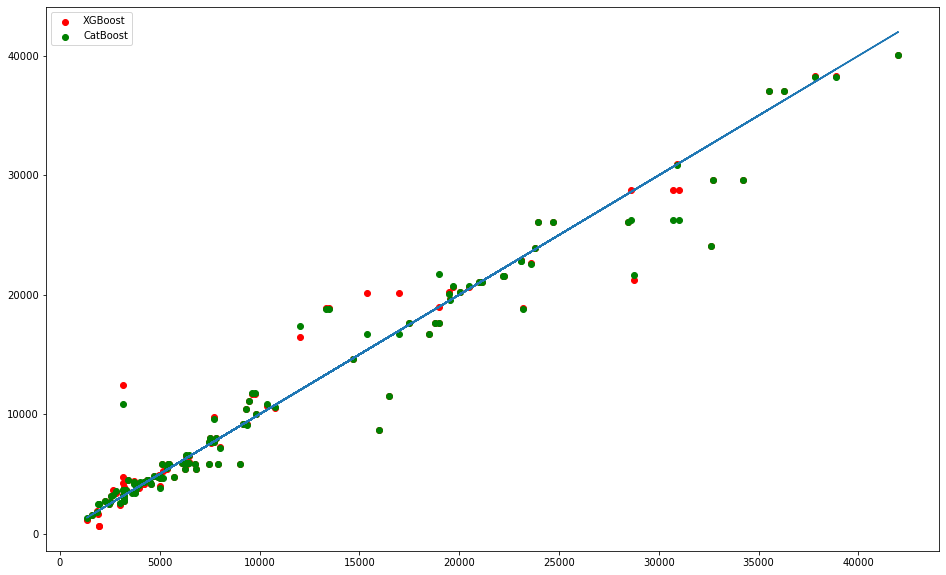

In [110]:
##  Visualize the predictions made by 2 different models. 
## CatBoostRegressor looks to be slightly better than XGBoostRegressor

plt.figure(figsize=(16,10))
plt.plot(y_test,y_test)
plt.scatter(y_test,y_pred1,color='r', label = 'XGBoost')
plt.scatter(y_test,y_pred2,color='g',label='CatBoost')
plt.legend()
plt.show()

In [111]:
pairs = {}               ## create a dictionary to convert the input brand names into the numerical values in the training. 
for k,v in zip(df1.Brand.unique(),np.arange(9)):
    pairs[k]=v
pairs

{'Apple': 0,
 'General Mobile': 1,
 'Huawei': 2,
 'Oppo': 3,
 'POCO': 4,
 'realme': 5,
 'Reeder': 6,
 'Samsung': 7,
 'TCL': 8}

**In the cell below, the code requires you to enter the desired features of a smartphone and predicts price for those product features.**

In [112]:
Brand = input('Brand :').lower().title().strip()
Brand = pairs[Brand]
if Brand =='apple':
    OS = 1
else:
    OS = 0
    
Cpu = input('Cpu:')
RAM = input('RAM:')
Storage= input('Storage:')
Cam= input('Camera Resolution:')
Scr= input('Screen Size:')


feat=np.array([Brand,Cpu,RAM,Storage,OS,Cam,Scr])
pricex = model2.predict(feat)                            ## input cell for user to define desired features. The model makes prediction

print(f'The Price of the product : {pricex}')

Brand :Apple
Cpu:2.8
RAM:8
Storage:32
Camera Resolution:20
Screen Size:6.25
The Price of the product : 9948.8330609456
